Importing all require modules and packages

In [19]:
# Importing all modelues and packages required
import sqlite3 as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import time
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,StackingClassifier
from lightgbm import LGBMClassifier

# Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [52]:
sns.set()
plt.rc('font', size=15)

Retrieving the dataset

In [2]:
#import opendatasets as od
#od.download("https` ://www.kaggle.com/competitions/titanic/data")

In [3]:
training = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

# to indicate whether the 
training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

# 1. Data Exploration

Data attributes
* `Survived` : Whether the passenger survived the shipwreck
* `Pclass` : A proxy for socio-economic status (SES) of the passenger - 1 = Upper, 2 = Middle, 3 = Lower
* `Sex` : Sex of the passenger
* `Age` : Age of the passenger. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
* `Sibsp` : Number of siblings/spouses the passenger has aboard the ship
* `Parch` : Number of parents / children the passenger has aboard the ship
* `Ticket` : Ticket number
* `Fare` : Passenger fare paid for the ticket
* `Cabin` : Cabin number of the passenger
* `Embarked` : Port of Embarkation	- C = Cherbourg, Q = Queenstown, S = Southampton


Taking a look at the training dataset

In [8]:
# quick look at the dataset
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [29]:
print("Dataset dimension: ",training.shape)

Dataset dimension:  (891, 13)


In [5]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


Null data are identified for `Age`, `Cabin` and `Embarked`

In [27]:
training.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
train_test       1
dtype: int64

Ticket for some passengers are the same and there are 248 unique pricing for total tickets


Splitting into numerical and categorical data


In [45]:
# PassengerId  will not be included since it is just an indexof the passenger
# "Survived" is the target variable
# "train_test" is to classify whether the data is from training or test dataset

num_df = training[["Age","SibSp","Parch","Fare"]] #5 
cat_df = training[["Name", "Pclass", "Sex","Ticket","Cabin","Embarked"]] #5

## 1a. Target variable

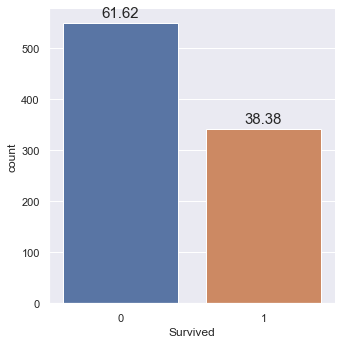

In [53]:
g = sns.catplot(x ="Survived", data = training , kind = "count",height = 5)

for ax in g.axes.ravel():
# obtaining the height of each bar graph
    ls = []
    for p in ax.patches:
        ls.append(p.get_height())

    # summing of all the total variables   
    total = 0
    for x in ls:
        total += x

    # Plotting the count plot
    for p in ax.patches:
        ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Survival rate of the passengers are low with 38% of passengers surviving. This might be considered imbalanced for classification and poised some difficulties during training later

## 1b. Numerical variables

In [47]:
num_df.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


Some passenger's `age` is missing from the dataset

<AxesSubplot:>

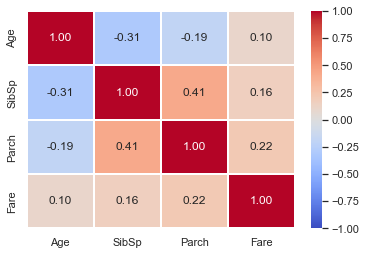

In [54]:
#f, axes = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(num_df.corr(), vmin = -1, vmax = 1, linewidths = 1.5,
           annot = True, fmt = ".2f", annot_kws = {"size": 12}, cmap = 'coolwarm')

* `Age` have a relative negative correlation to `SibSp`, which might suggest that the older someone is, the seller number of siblings/spouse is onboard the ship.

In [43]:
# Creating a plotting function for boxplot, histogram and violin plot for the variables
def plotting(data,a):
    f, axes = plt.subplots(3, figsize=(16, 12))
    sns.boxplot(data = data, x = data[a], orient = "h", color = 'r' , ax = axes[0])
    sns.histplot(data = data[a], color = 'g', ax = axes[1])
    sns.violinplot(data = data[a], orient = "h",ax = axes[2])

### i) Age variable

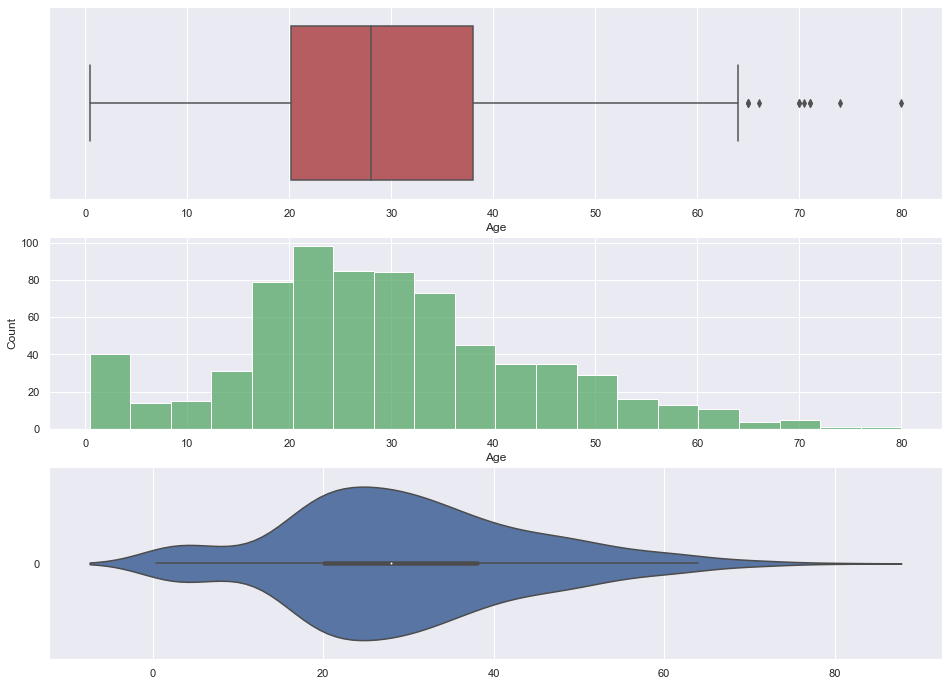

In [55]:
plotting(num_df,"Age")

### ii) SibSp

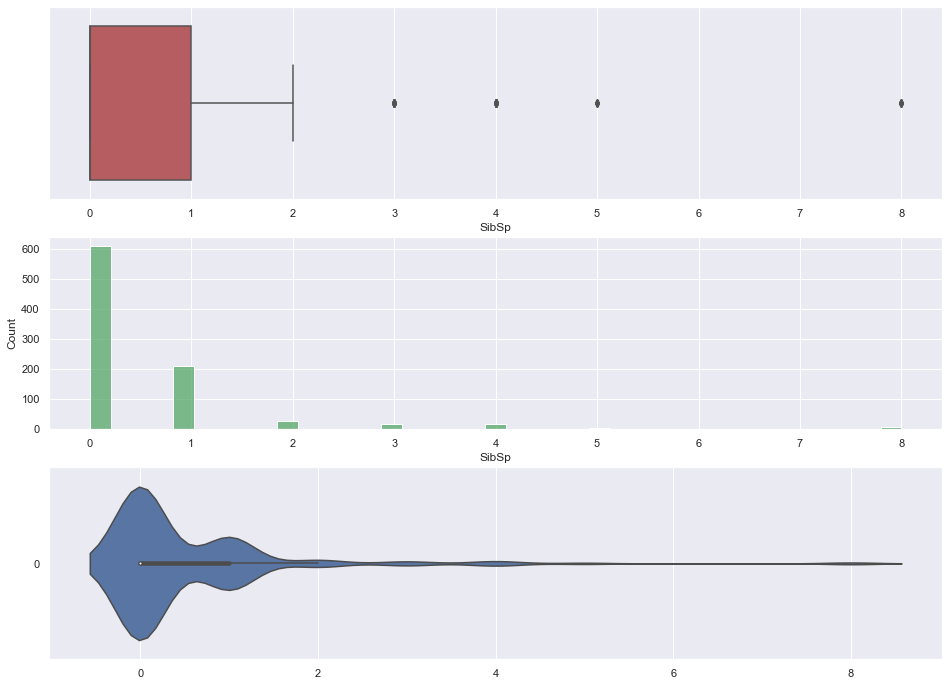

In [56]:
plotting(num_df,"SibSp")

### iii) Parch

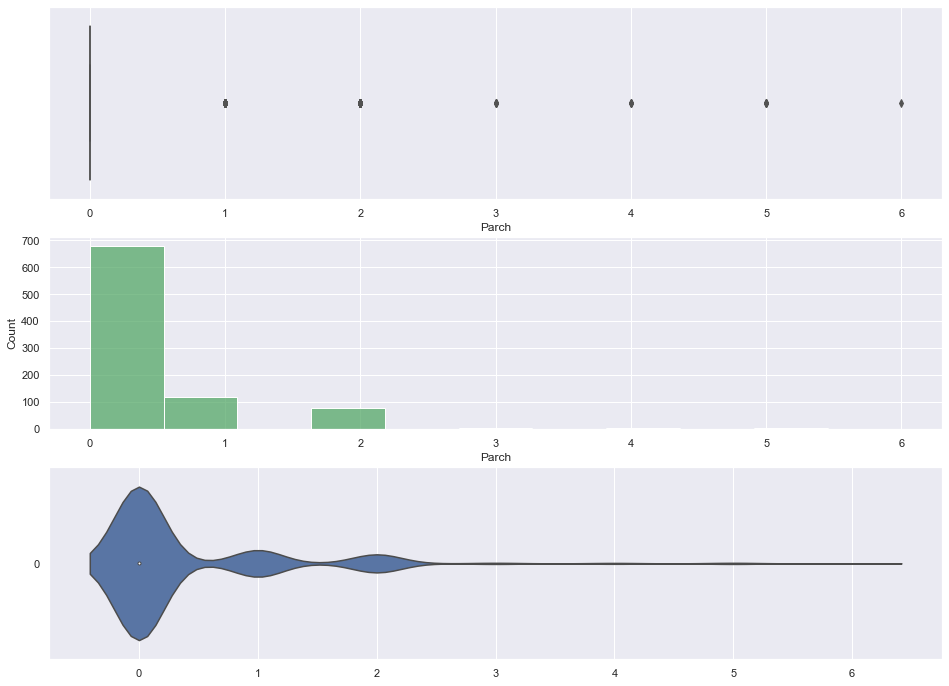

In [57]:
plotting(num_df,"Parch")

### iv) Fare

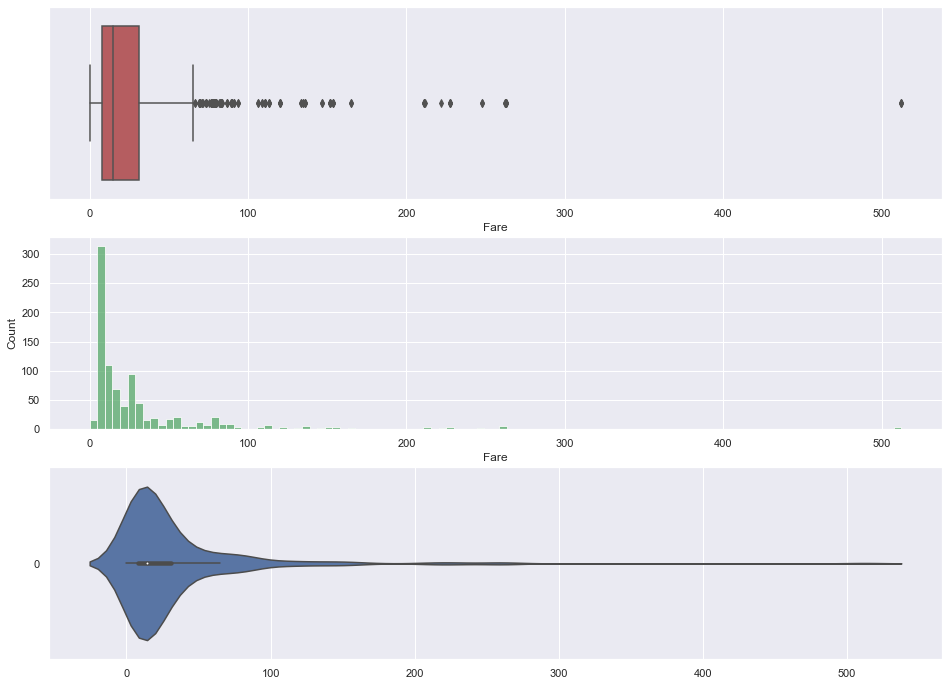

In [58]:
plotting(num_df,"Fare")

The distribution for fare is right skewed. It is weird that some passenger's fare is 0

## 1c. Categorical variables

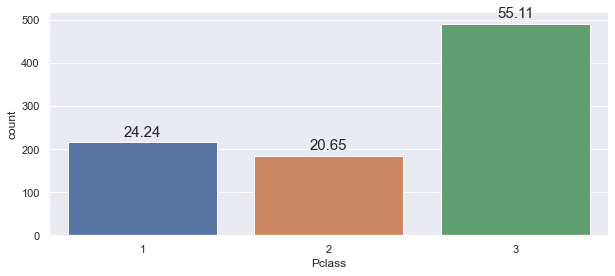

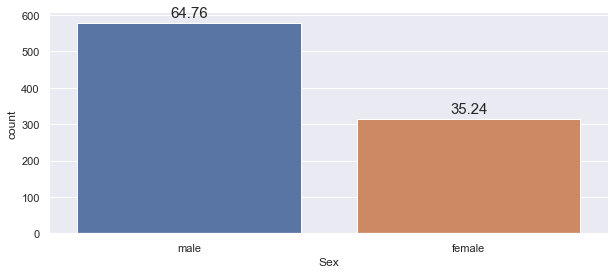

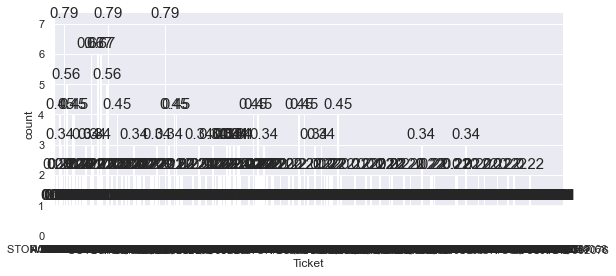

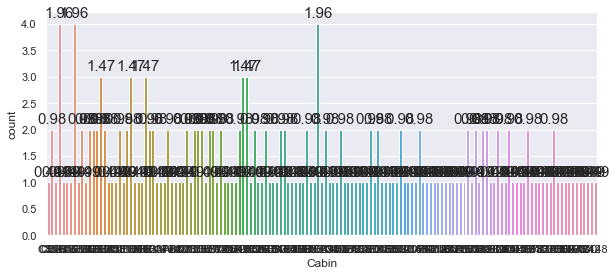

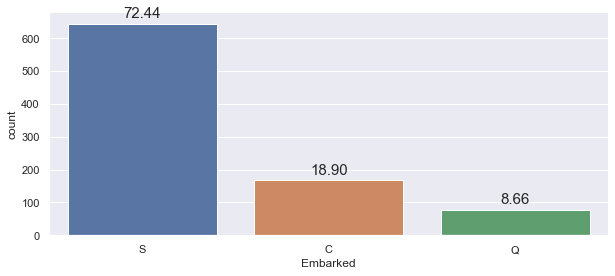

In [73]:
for var in cat_df:
    # Skipping the predictor variable Name
    if var =="Name":
        continue
    else:
        g = sb.catplot(x = var, data = cat_df , kind = "count",height = 4,aspect = 2.2)
        for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

#### i) Cabin Variable

In [86]:
# Taking a closer looking at the unique cabin number of each passenger
cat_df["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [99]:
training.sort_values(by="Cabin").head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
583,584,0,1,"Ross, Mr. John Hugo",male,36.0,0,0,13049,40.1250,A10,C,1
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S,1
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,1
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S,1
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,1
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,1
867,868,0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S,1
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C,1
209,210,1,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,A31,C,1
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A32,S,1


In [89]:
training[cat_df["Cabin"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,1
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,1
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1


#### ii) Name

In [95]:
training.sort_values(by='Name')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
845,846,0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.5500,NaN,S,1
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,1
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S,1
308,309,0,2,"Abelson, Mr. Samuel",male,30.0,1,0,P/PP 3381,24.0000,NaN,C,1
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S,1
282,283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,1
361,362,0,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,SC/PARIS 2167,27.7208,NaN,C,1
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S,1


## 1d. Relationship between categorical variables and target variable "Survived"

In [97]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'),"\n")
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'),"\n")
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'),"\n")

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119 

Sex       female  male
Survived              
0             81   468
1            233   109 

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217 



### i) Pclass vs Survived


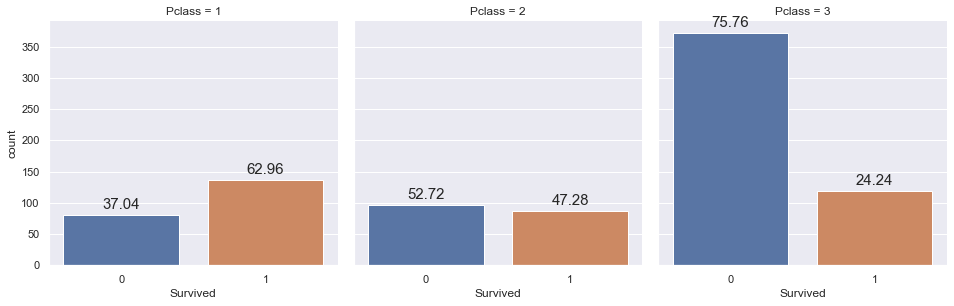

In [81]:
#plt.rc('font', size=12)
g=sns.catplot(data = training, x = 'Survived', col = 'Pclass', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

For Pclass, it seems that the higher SES the passengers are, the greater chance of survival.

### ii) Sex vs Survived

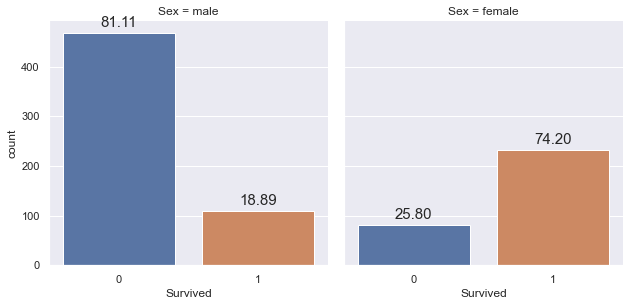

In [74]:
#plt.rc('font', size=12)
g=sb.catplot(data = training, x = 'Survived', col = 'Sex', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

A higher proportion of Female survived the shipwreck

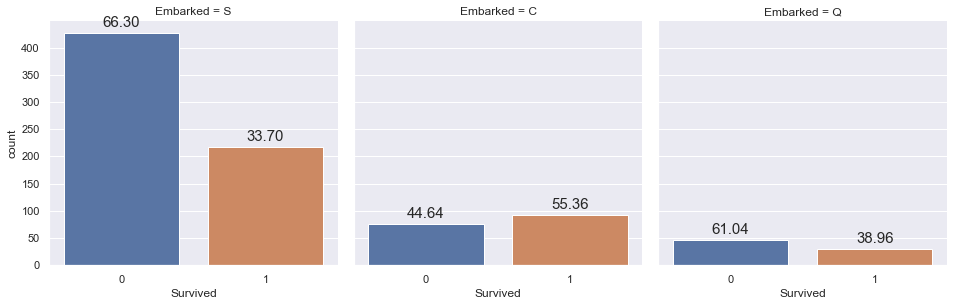

In [75]:
#plt.rc('font', size=12)
g=sb.catplot(data = training, x = 'Survived', col = 'Embarked', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# 2. Feature Engineering

1) Does a person's tite relate to survival rate?
2) Does different ticket type relate to survival rate?

In [90]:
cat_df

,Name,Pclass,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",3,male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",3,female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,113803,C123,S
4,"Allen, Mr. William Henry",3,male,373450,NaN,S
...,...,...,...,...,...,...
886,"Montvila, Rev. Juozas",2,male,211536,NaN,S
887,"Graham, Miss. Margaret Edith",1,female,112053,B42,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",3,female,W./C. 6607,NaN,S
889,"Behr, Mr. Karl Howell",1,male,111369,C148,C


In [100]:
#understand ticket values better 
#numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['text_ticket'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [103]:
training

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,numeric_ticket,text_ticket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,a5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,pc
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,stono2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1,1,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1,0,wc
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,1,0


In [102]:
pd.set_option("max_rows", None)
training['text_ticket'].value_counts()

OptionError: 'Pattern matched multiple keys'